In [1]:
from IPython import display
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import (
    pyplot as plt,
    ticker,
)
from tqdm.notebook import tqdm
from pprint import pp
import requests
import json
import ast
import librosa
import whisper
import torch
import jiwer
import warnings
warnings.filterwarnings(
    action="ignore",
    message="PySoundFile.*",
    category=FutureWarning,
    module=".*",
)

plt.style.use("minimal.mplstyle")

class COLORMAP:
    F1_red = "#E10600"

audio_files_path = Path() / "data" / "radio_messages/"

- ALEALB01_23_20240229_154846 optics > upshift
- LANNOR01_4_20250419_205244 im an f'ing idiot
- MAXVER01_1_20250413_181201 lado > lando
- LANNOR01_4_20240824_122457 landon > lando
- LANNOR01_4_20250906_163307 map > lap
- LANNOR01_4_20241201_113249 can't hear your – strat 10!!!
- MAXVER01_1_20251109_152028 deck > deg(radation)
- ANDANT01_12_20250316_170136 [silence gets transcribed as "thank you"] 
- LIALAW01_30_20250615_151510 peel > PU
- GUAZHO01_24_20240706_113306 upship > upshift

In [2]:
def get_json(url):
    return requests.get(url).json()

radio_messages = pd.merge(
    left=pd.DataFrame.from_records(get_json("https://api.openf1.org/v1/team_radio")),
    right=pd.DataFrame.from_records(get_json("https://api.openf1.org/v1/sessions"))[[
        "session_key",
        "location",
        "year",
        "session_name",
    ]],
    on="session_key",
    how="left",
).rename(columns=dict(
    date="timestamp",
)).astype(dict(
    timestamp="datetime64[ns, UTC]",
)).sort_values("timestamp")

radio_messages["identifier"] = radio_messages["recording_url"].str.split("/").str[-1]
radio_messages["file_path"] = (audio_files_path / radio_messages["identifier"]).astype(str)

# radio_messages.info(memory_usage=False)
print(f"Found {len(radio_messages)} radio messages")
radio_messages.tail(3)

Found 16420 radio messages


,meeting_key,session_key,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path
16320,1276,9839,4,2025-12-07 14:25:01.949000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,LANNOR01_4_20251207_182444.mp3,data/radio_messages/LANNOR01_4_20251207_182444...
16321,1276,9839,4,2025-12-07 14:32:13.730000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,LANNOR01_4_20251207_183123.mp3,data/radio_messages/LANNOR01_4_20251207_183123...
16322,1276,9839,1,2025-12-07 14:33:14.515000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,MAXVER01_1_20251207_183223.mp3,data/radio_messages/MAXVER01_1_20251207_183223...


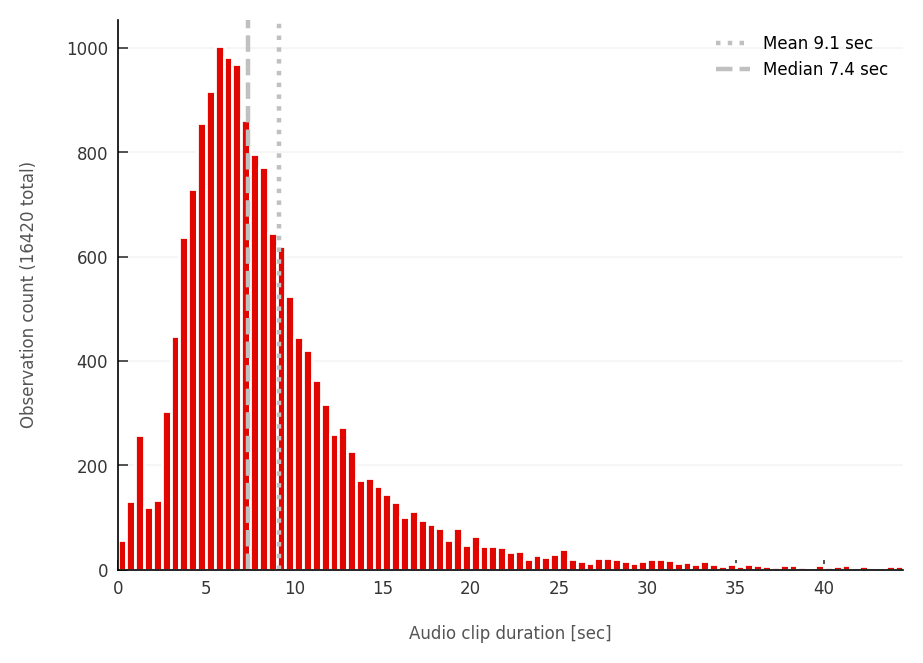

In [3]:
def get_clip_duration(file_path):
    try:
        return librosa.get_duration(path=file_path)
    except:
        return np.nan

if not "clip_duration" in radio_messages.columns:
    radio_messages["clip_duration"] = radio_messages["file_path"].apply(get_clip_duration)
    # radio_messages = radio_messages[radio_messages["clip_duration"] < 30]

plt.hist(
    radio_messages["clip_duration"],
    bins=np.arange(0, 45, 0.5),
    # density=True,
    color=COLORMAP.F1_red,
    edgecolor="white",
    linewidth=1,
)
plt.axvline(
    x=radio_messages["clip_duration"].mean(),
    color="silver",
    linestyle="dotted",
    label=f"Mean {radio_messages["clip_duration"].mean():.1f} sec",
)
plt.axvline(
    x=radio_messages["clip_duration"].median(),
    color="silver",
    linestyle="dashed",
    label=f"Median {radio_messages["clip_duration"].median():.1f} sec",
)
plt.legend(loc="upper right")
plt.xlabel("Audio clip duration [sec]")
# plt.ylabel("Probability density")
plt.ylabel(f"Observation count ({len(radio_messages)} total)")
plt.show()

In [4]:
def download_audiofiles(file_path_todo_list):
    for _, radio_message in tqdm(list(file_path_todo_list), smoothing=0):
        if not Path(radio_message["file_path"]).exists():
            try:
                with open(radio_message["file_path"], mode="wb") as file:
                    file.write(requests.get(radio_message["recording_url"]).content)
            except:
                print("Failed on", radio_message["file_path"])

download_audiofiles(
    file_path_todo_list=radio_messages[~radio_messages["file_path"].apply(Path).apply(Path.exists)][["recording_url", "file_path"]].iloc[::-1].iterrows(),
)

0it [00:00, ?it/s]

---

In [9]:
transcriptions = pd.read_csv("data/transcriptions.tsv", delimiter="\t").astype(dict(
    transcription_timestamp="datetime64[ns, UTC]",
))

radio_messages_transcribed = pd.merge(
    left=radio_messages.drop(columns=[
        "meeting_key",
        "session_key",
    ]),
    right=transcriptions,
    on="identifier",
    how="left",
).sort_values("transcription_timestamp").drop_duplicates(
    subset="file_path",
    keep="first",
)
radio_messages_transcribed = radio_messages_transcribed[~radio_messages_transcribed["transcription"].isna()]

print(f"Found {len(radio_messages_transcribed)} transcribed radio messages")
radio_messages_transcribed.tail(3)

Found 345 transcribed radio messages


,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path,clip_duration,transcription_timestamp,modeltype,transcription,avg_logprob,text_nbest,no_speech_prob,temperature,compression_ratio,sum_logprob_nbest,token_nbest
11797,55,2024-08-25 13:29:31.123000+00:00,https://livetiming.formula1.com/static/2024/20...,Zandvoort,2024,Race,CARSAI01_55_20240825_152902.mp3,data/radio_messages/CARSAI01_55_20240825_15290...,6.120,2025-12-09 20:58:10.205609+00:00,base.en,and I will turn it up time 6.7 or soft behind ...,-0.738876,['and I will turn it up time 6.7 or soft behin...,0.075914,0.0,0.881356,"[-11.335271835327148, -11.972057342529297, -12...","[[290, 314, 481, 1210, 340, 510, 640, 718, 13,..."
9378,3,2024-05-24 11:49:35.607000+00:00,https://livetiming.formula1.com/static/2024/20...,Monaco,2024,Practice 1,DANRIC01_3_20240524_134906.mp3,data/radio_messages/DANRIC01_3_20240524_134906...,3.816,2025-12-09 20:58:10.205640+00:00,base.en,And you can consider N39 if you need more stab...,-0.310157,['And you can consider N39 if you need more st...,0.158848,0.0,0.912281,"[-4.2039031982421875, -4.239250659942627, -4.0...","[[843, 345, 460, 2074, 399, 2670, 611, 345, 76..."
15316,22,2025-05-23 12:28:49.137000+00:00,https://livetiming.formula1.com/static/2025/20...,Monaco,2025,Practice 1,YUKTSU01_22_20250523_142821.mp3,data/radio_messages/YUKTSU01_22_20250523_14282...,8.328,2025-12-09 20:58:10.580989+00:00,base.en,"Yeah, copy that. It wasn't very nice.",-0.518557,"['Yeah, copy that. That was very nice.', ""Yeah...",0.263107,0.0,0.822222,"[-6.781318187713623, -9.115450859069824, -6.22...","[[9425, 11, 4866, 326, 13, 1320, 373, 845, 362..."


In [12]:
most_recent_label_export = pd.read_json(sorted(Path("label-studio/export").iterdir())[-1]).rename(columns=dict(
    transcription="human_transcription",
))
most_recent_label_export["file_path"] = most_recent_label_export["audio"].str.split("=").str[-1]

radio_messages_transcribed_with_reference = pd.merge(
    left=radio_messages_transcribed,
    right=most_recent_label_export[[
        "identifier",
        "human_transcription",
        "lead_time",
        "updated_at",
    ]].rename(columns=dict(updated_at="human_transcription_timestamp")),
    on="identifier",
    how="left",
).sort_values("human_transcription_timestamp")

example_list = []
for _, message in radio_messages_transcribed_with_reference.iterrows():
    preannotation = message["human_transcription"] if type(message["human_transcription"]) is str else "\n" + message["transcription"].lstrip()
    example_list.append(dict(
        data=dict(
            audio=f"""/data/local-files/?d={message["file_path"]}""",
            identifier=message["identifier"],
        ),
        annotations=[dict(
            result=[dict(
                value=dict(
                    text=[message["human_transcription"]],
                ),
                from_name="transcription",
                to_name="audio",
                type="textarea",
                origin="manual",
            )],
            # ground_truth=True,
        )] if type(message["human_transcription"]) is str else [],
        predictions=[dict(
            result=[dict(
                value=dict(
                    text=[message["transcription"]],
                ),
                from_name="transcription",
                to_name="audio",
                type="textarea",
            )],
        )],
        total_annotations=int(type(message["human_transcription"]) is str),
    ))

with open("label-studio/media/upload/annotation_tasks.json", mode="w") as file:
    json.dump(example_list, file)

radio_messages_transcribed_with_reference = radio_messages_transcribed_with_reference[~radio_messages_transcribed_with_reference["human_transcription"].isna()]

print(f"Found {len(radio_messages_transcribed_with_reference)} transcribed radio messages with reference")
radio_messages_transcribed_with_reference.sample(3)

Found 349 transcribed radio messages with reference


,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path,clip_duration,transcription_timestamp,...,avg_logprob,text_nbest,no_speech_prob,temperature,compression_ratio,sum_logprob_nbest,token_nbest,human_transcription,lead_time,human_transcription_timestamp
245,4,2025-10-05 12:28:26.613000+00:00,https://livetiming.formula1.com/static/2025/20...,Marina Bay,2025,Race,LANNOR01_4_20251005_202755.mp3,data/radio_messages/LANNOR01_4_20251005_202755...,9.816,2025-12-09 20:57:11.676028+00:00,...,-0.270543,['The currently three or four cars on the wind...,0.118786,0.0,1.111111,"[-5.838281631469727, -5.681396961212158, -6.31...","[[383, 3058, 1115, 393, 1440, 5006, 319, 262, ...","There's currently 3 or 4 cars on the window, ...",49.043,2025-12-07 10:48:52.286742+00:00
342,30,2025-06-15 19:15:35.626000+00:00,https://livetiming.formula1.com/static/2025/20...,Montréal,2025,Race,LIALAW01_30_20250615_151510.mp3,data/radio_messages/LIALAW01_30_20250615_15151...,10.848,2025-12-09 20:58:07.223508+00:00,...,-0.175727,"[""Sorry mate, it's a hard day and this is the ...",0.182559,0.0,1.130952,"[-4.568904399871826, -4.8198981285095215, -6.3...","[[19061, 16133, 11, 340, 338, 257, 1327, 1110,...","Sorry, mate. It's a hard day and this is the ...",13.153,2025-12-07 11:34:12.268787+00:00
72,55,2024-06-09 18:00:09.708000+00:00,https://livetiming.formula1.com/static/2024/20...,Montréal,2024,Race,CARSAI01_55_20240609_152113.mp3,data/radio_messages/CARSAI01_55_20240609_15211...,4.296,2025-12-09 20:34:57.873147+00:00,...,-0.383560,"['Try to save the tyres and attack', 'try to s...",0.044746,0.0,0.842105,"[-3.068478584289551, -3.2044434547424316, -3.7...","[[9993, 284, 3613, 262, 40498, 290, 1368], [19...","Try to save the tires, and attack.",NaN,2025-12-07 10:31:30.927788+00:00


In [17]:
radio_messages_transcribed_with_reference.to_json(
    "data/transcribed_with_reference.json", 
    index=False,
    orient="records",
)

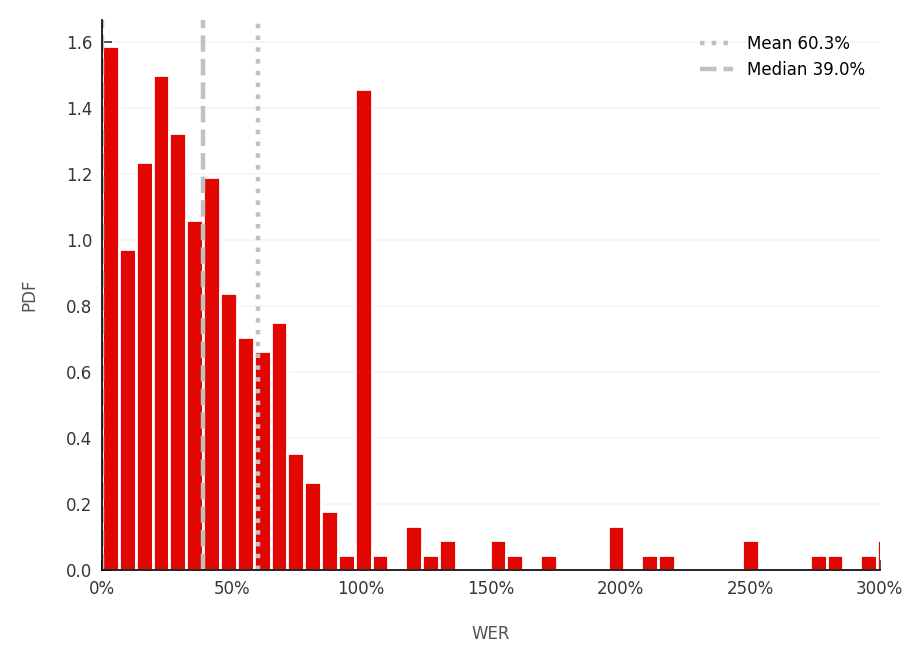

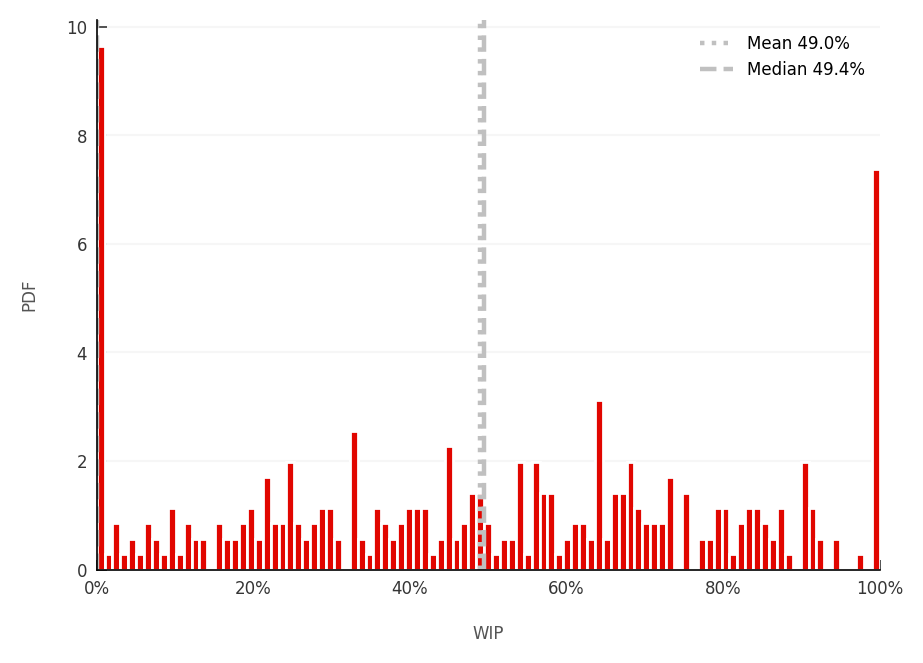

In [13]:
from whisper.normalizers import EnglishTextNormalizer
word_normalizer = EnglishTextNormalizer()

for metric, estimator in [
    ("wer", jiwer.wer),
    ("wip", jiwer.wip),
]:
    radio_messages_transcribed_with_reference[metric] = radio_messages_transcribed_with_reference.apply(lambda radio_message: estimator(
        word_normalizer(radio_message["transcription"]),
        word_normalizer(radio_message["human_transcription"]),
    ), axis=1)
    plt.hist(
        radio_messages_transcribed_with_reference[metric],
        bins=dict(
            wer=200,
            wip=np.linspace(0, 1, 100),
        )[metric],
        density=True,
        color=COLORMAP.F1_red,
        edgecolor="white",
        linewidth=1,
    )
    plt.axvline(
        color="silver",
        linestyle="dashed",
    )
    plt.axvline(
        x=radio_messages_transcribed_with_reference[metric].mean(),
        color="silver",
        linestyle="dotted",
        label=f"Mean {radio_messages_transcribed_with_reference[metric].mean():.1%}",
    )
    plt.axvline(
        x=radio_messages_transcribed_with_reference[metric].median(),
        color="silver",
        linestyle="dashed",
        label=f"Median {radio_messages_transcribed_with_reference[metric].median():.1%}",
    )
    plt.legend(loc="upper right")
    plt.xlabel(metric.upper())
    plt.ylabel("PDF")
    if metric == "wip":
        plt.xlim(0, 1)
    elif metric == "wer":
        plt.xlim(0, 3)
    plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.show()

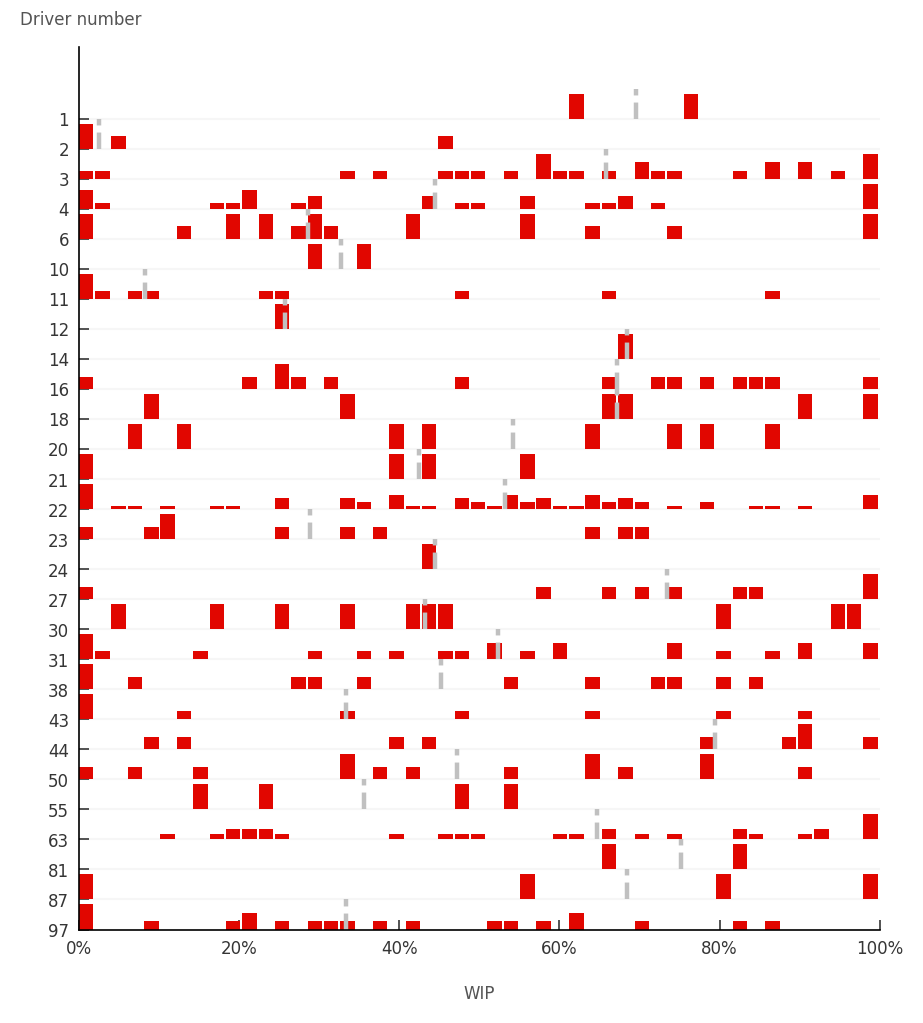

In [14]:
fig, ax = plt.subplots(figsize=(4.5, 5))

for row_idx, (driver_number, driver_data) in enumerate(radio_messages_transcribed_with_reference.groupby("driver_number")):
    hist, bin_edges = np.histogram(
        driver_data["wip"],
        bins=np.linspace(0, 1, 50),
    )
    plt.bar(
        x=bin_edges[:-1],
        height=np.array(hist) / max(hist) / 1.2,
        bottom=row_idx,
        width=0.018,
        color=COLORMAP.F1_red,
        align="edge",
    )
    plt.vlines(
        x=driver_data["wip"].median(),
        ymin=row_idx,
        ymax=row_idx + 1,
        color="silver",
        linestyle="dashed",
    )

plt.yticks(range(radio_messages_transcribed_with_reference["driver_number"].nunique()), radio_messages_transcribed_with_reference["driver_number"].sort_values(ascending=False).unique())
plt.ylabel("Driver number", y=1.02, rotation=0, ha="left")
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xlim(0, 1)
plt.xlabel("Clip duration [sec]")
plt.xlabel("WIP")
plt.show()

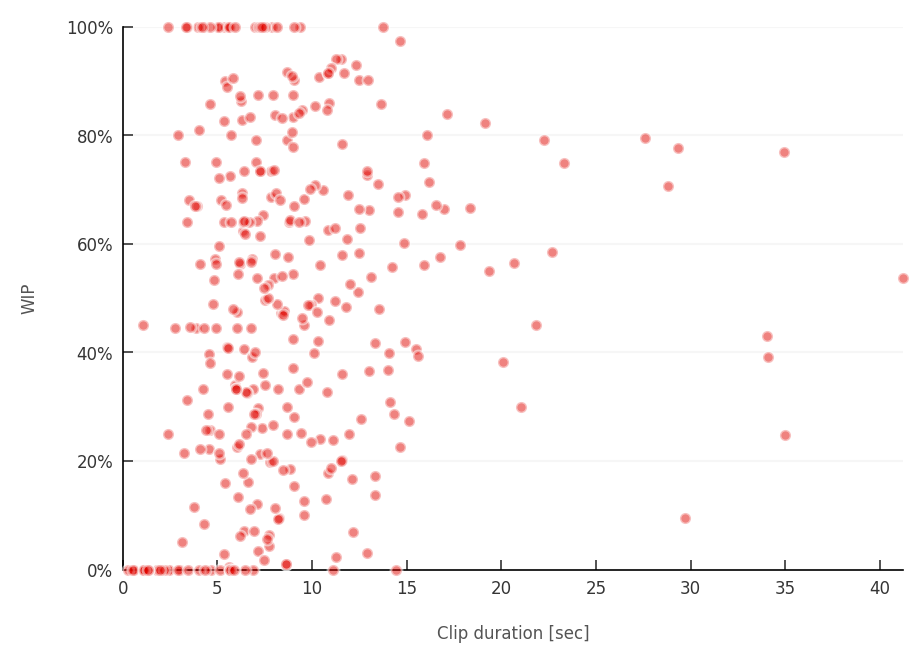

In [15]:
plt.scatter(
    radio_messages_transcribed_with_reference["clip_duration"],
    radio_messages_transcribed_with_reference["wip"],
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xlim(0)
plt.ylim(0, 1)
plt.xlabel("Clip duration [sec]")
plt.ylabel("WIP")
plt.show()

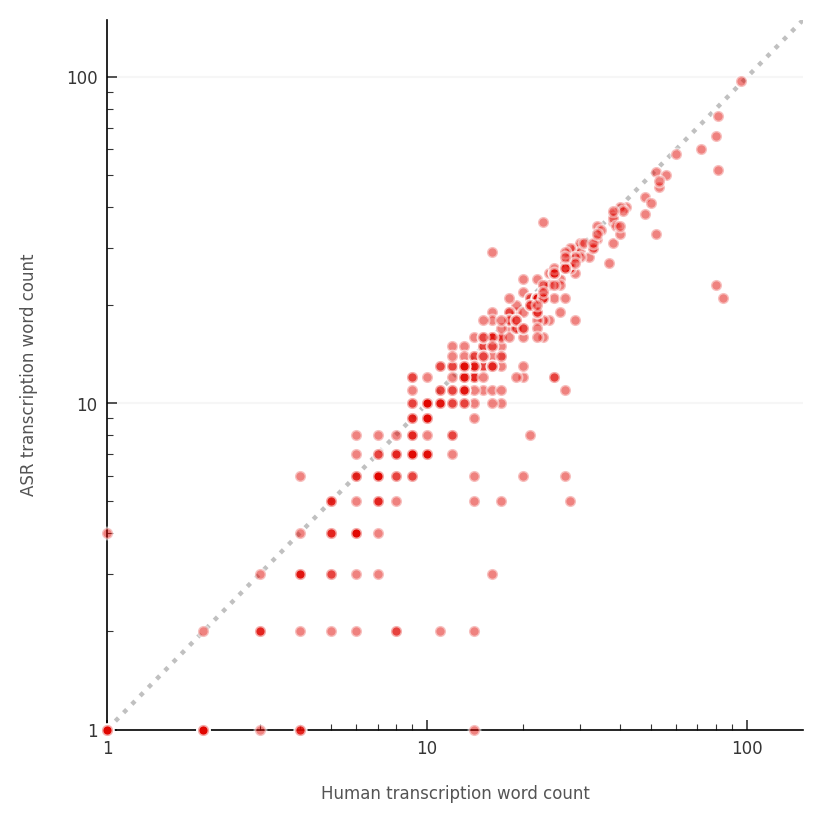

In [16]:
plt.figure(figsize=(4, 4))
plt.scatter(
    radio_messages_transcribed_with_reference["human_transcription"].str.split(" ").str.len(),
    radio_messages_transcribed_with_reference["transcription"].str.split(" ").str.len(),
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.plot(
    [0, 1],
    [0, 1],
    transform=plt.gca().transAxes,
    color="silver",
    linestyle="dotted",
    zorder=-1,
)
plt.xscale("log", base=10)
plt.yscale("log", base=10)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xlim(1, 150)
plt.ylim(1, 150)
plt.xlabel("Human transcription word count")
plt.ylabel("ASR transcription word count")
plt.show()

<!-- ln -s radio_messages/ /home/ucloud/.local/share/label-studio/radio_messages -->